## Time to get your hands dirty! Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

These are some (synthetic but realistic; see textbook) supernova data.

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [143]:
import warnings
warnings.simplefilter('ignore')
from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_predict
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
import numpy as np
from astroML.linear_model import NadarayaWatson
from sklearn.model_selection import GridSearchCV
import seaborn as sns

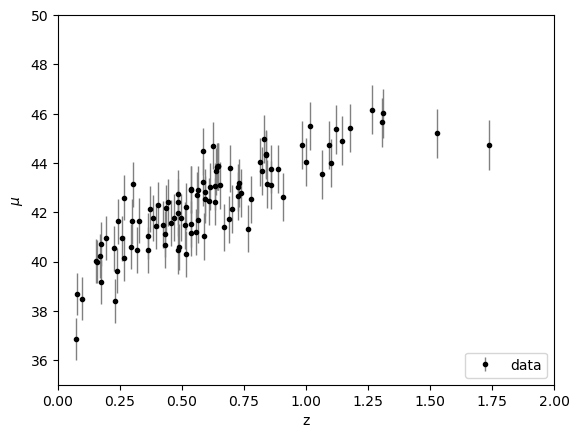

In [92]:
n = 100
z_sample, mu_sample, dmu = generate_mu_z(n, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

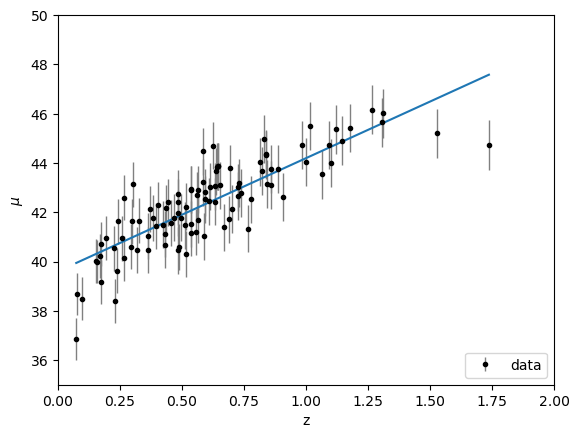

In [93]:
lin = LinearRegression()
lin.fit(z_sample[:, None], mu_sample, dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.plot(np.sort(z_sample), lin.predict(np.sort(z_sample)[:, None]));

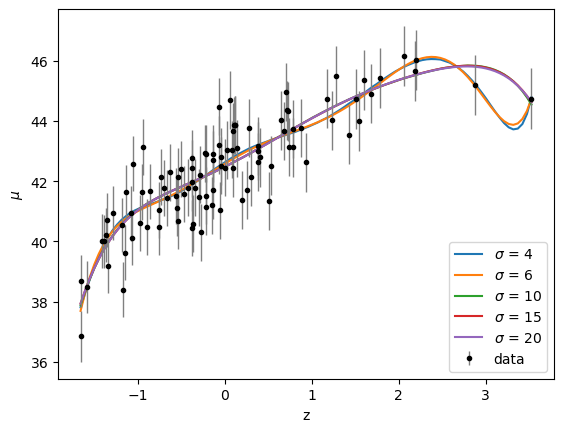

In [95]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
z_lin = np.linspace(min(z_test), max(z_test), 100)
sigmatest = [4,6,10,15,20]
for sigma in sigmatest:
  basis = BasisFunctionRegression('gaussian', mu=z_lin, sigma=sigma)
  basis.fit(z_test, mu_sample, dmu)
  plt.plot(z_lin, basis.predict(z_lin), label = r'$\sigma$ = '+str(sigma))

plt.errorbar(z_test, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right');

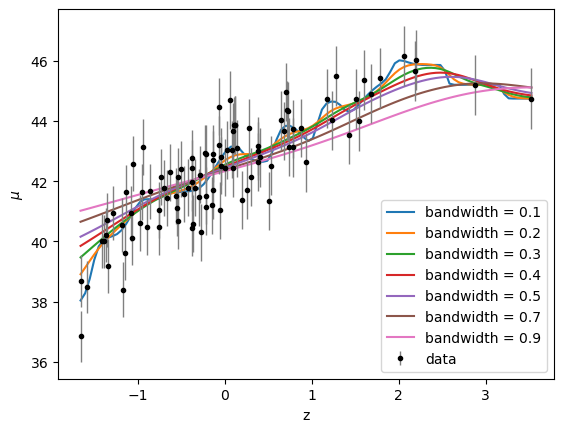

In [96]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
z_lin = np.linspace(min(z_test), max(z_test), 100)
bandwidth = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
for h in bandwidth:
    model = NadarayaWatson(kernel='gaussian', h=h)
    model.fit(z_test,mu_sample)
    plt.plot(z_lin, model.predict(z_lin), label = 'bandwidth = '+str(h))

plt.errorbar(z_test, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right');

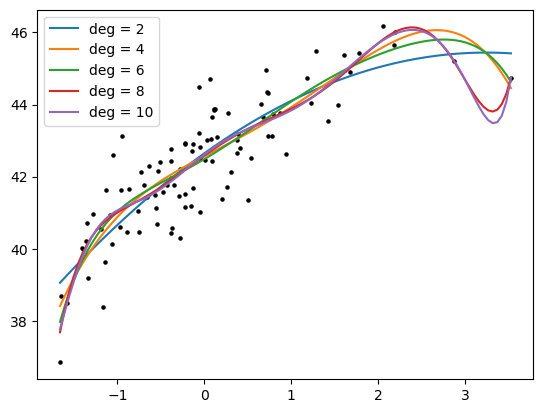

In [97]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
z_lin = np.linspace(min(z_test), max(z_test), n)
degree = [2,4,6,8,10]
for deg in degree:
    model = PolynomialRegression(deg) # fit degth degree polynomial
    model.fit(z_test, mu_sample)
    plt.plot(z_lin, model.predict(z_lin), label = 'deg = '+ str(deg))

plt.scatter(z_test, mu_sample, s = 5, color = 'black')
plt.legend()
plt.show()

Intuition: best fit is 2 or 4 degrees polynomial, while i'm underfitting when only 1 degree and overfitting with parameters higher than 6.

Optimal parameter with K-fold (K = 10):  5


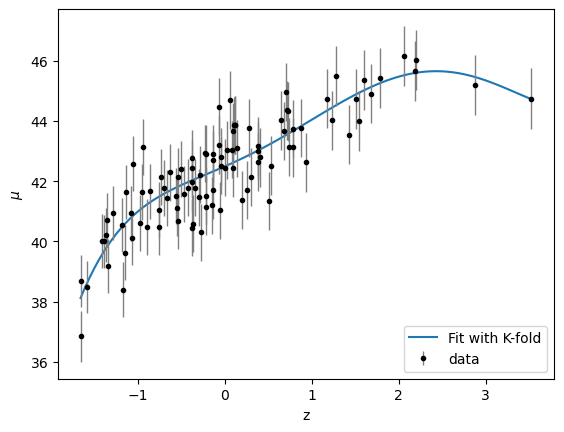

In [98]:
degrange = np.arange(1,10)
K = 10
grid = GridSearchCV(PolynomialRegression(), {'degree': degrange}, scoring = 'neg_root_mean_squared_error', cv= K)
grid.fit(z_test, mu_sample)
h_opt = grid.best_params_['degree']
print('Optimal parameter with K-fold (K = 10): ', h_opt)

model = PolynomialRegression(h_opt) # fit degth degree polynomial
model.fit(z_test, mu_sample)
plt.plot(z_lin, model.predict(z_lin), label = 'Fit with K-fold')
plt.errorbar(z_test, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right');

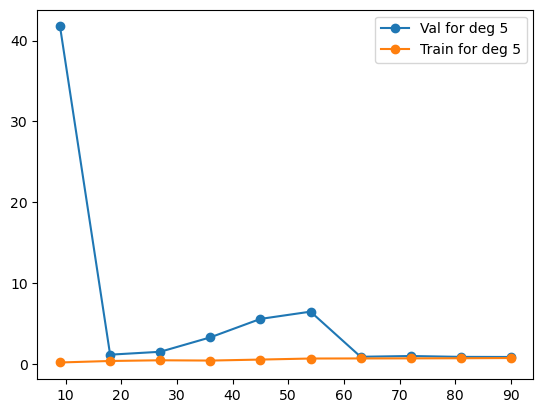

In [99]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
degree = [5]
x = 0
for deg in degree:
    model = PolynomialRegression(deg) # fit degth degree polynomial
    model.fit(z_test, mu_sample)
    train_sizes, train_scores_mod, test_scores_mod = \
    learning_curve(model, z_test, mu_sample, train_sizes=np.linspace(0.1, 1, 10), \
                   scoring="neg_mean_squared_error", cv=K)
    plt.plot(train_sizes[x:], -test_scores_mod.mean(1)[x:], 'o-', label="Val for deg "+str(deg))
    plt.plot(train_sizes[x:], -train_scores_mod.mean(1)[x:], 'o-', label="Train for deg "+str(deg))
plt.legend()
plt.show()

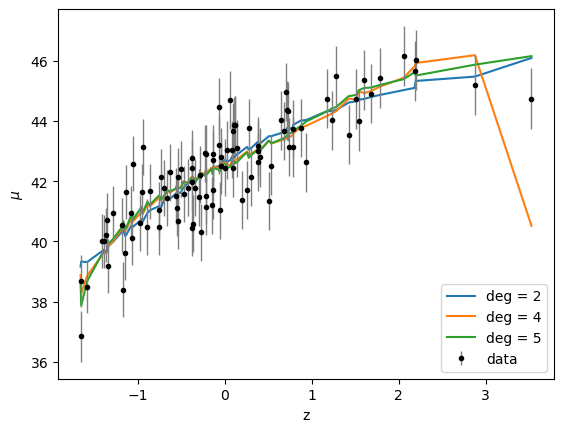

In [144]:
degree = [2,4,5]
for deg in degree:
    model = PolynomialRegression(deg) # fit degth degree polynomial
    model.fit(z_test, mu_sample)
    ypred = cross_val_predict(model, z_test, mu_sample, cv=K)
    sns.lineplot(x=z_test[:, 0], y = ypred, label = 'deg = '+str(deg))  #to have lineplot from sampling

plt.errorbar(z_test, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right');

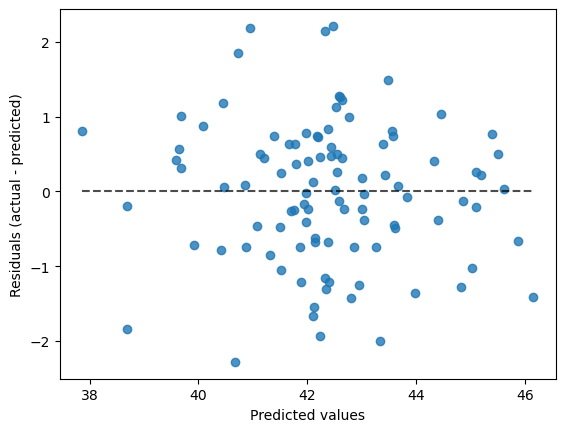

In [150]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay.from_predictions(y_true=mu_sample, y_pred=ypred);

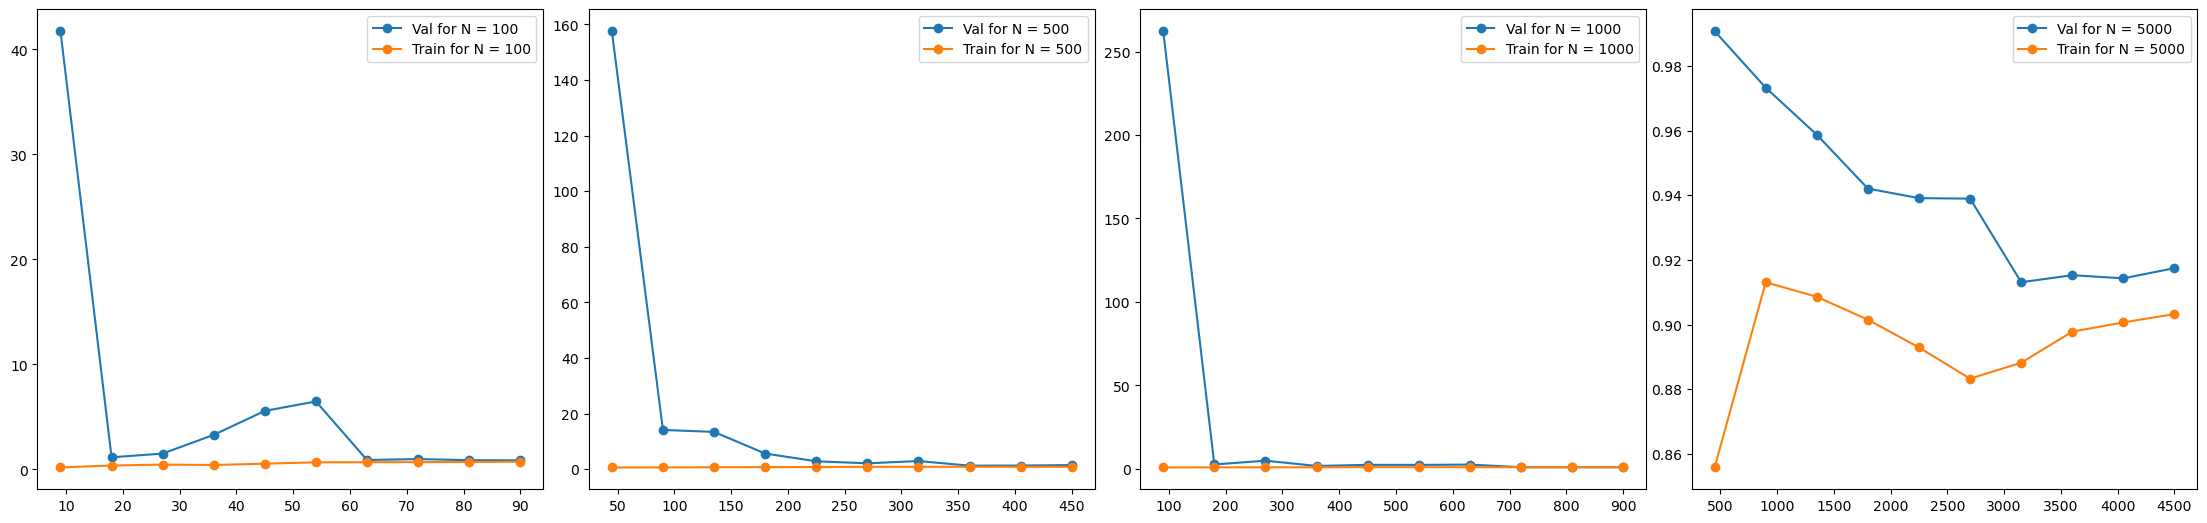

In [204]:
N = [100, 500, 1000, 5000]

fig = plt.figure(figsize=(24, 6))
fig.subplots_adjust(wspace=0.09, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for idx, num in enumerate(N):
    z_sample, mu_sample, dmu = generate_mu_z(num, random_state=1234)
    scaler = StandardScaler()
    z_test = scaler.fit_transform(z_sample[:, None])
    model = PolynomialRegression(5) # fit degth degree polynomial
    model.fit(z_test, mu_sample)
    train_sizes, train_scores_mod, test_scores_mod = \
    learning_curve(model, z_test, mu_sample, train_sizes=np.linspace(0.1, 1, 10), \
                   scoring="neg_mean_squared_error", cv=K)
    ax = fig.add_subplot(141 + idx)
    ax.plot(train_sizes[x:], -test_scores_mod.mean(1)[x:], 'o-', label="Val for N = "+str(num))
    ax.plot(train_sizes[x:], -train_scores_mod.mean(1)[x:], 'o-', label="Train for N = "+str(num))
    plt.legend()
plt.show()

Do this reducing the sampling size also and check the fit for the 0.1 and 0.5 to see why there is the spike. The 500 point in the right plot is the 500 point in the third plot (to understand the scale)